In [7]:
# Initialising packages
import numpy as np
import matplotlib.pyplot as plt
import sys
#change this folder so the import is correct
sys.path.append(r"C:\Users\kento\Documents\University of Manchester\University Work\Fourth Year\MPhys\MPhys---VUV-Photosensor-Testing-for-Neutrino-and-Dark-Matter-Detectors\My code\utils\\")
from scipy.stats import norm

from scipy.stats import moyal # Might work in place of landau. I am still hoping to install landau
from landaupy import landau
from landaupy import langauss

from copy import deepcopy
from iminuit import Minuit
from iminuit import cost
from scipy.optimize import curve_fit
DATA_FOLDER = r"C:\Users\kento\Documents\University of Manchester\University Work\Fourth Year\MPhys\MPhys---VUV-Photosensor-Testing-for-Neutrino-and-Dark-Matter-Detectors\My code\data\\"
PLOTS_FOLDER = r"C:\Users\kento\Documents\University of Manchester\University Work\Fourth Year\MPhys\MPhys---VUV-Photosensor-Testing-for-Neutrino-and-Dark-Matter-Detectors\My code\plots\\"
RESULTS_FOLDER = r"C:\Users\kento\Documents\University of Manchester\University Work\Fourth Year\MPhys\MPhys---VUV-Photosensor-Testing-for-Neutrino-and-Dark-Matter-Detectors\My code\results\\"
# from plotting_utils import plot2d
import matplotlib.colors
import matplotlib.cm as colormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

### from utils folder

In [8]:
def plot2d(h, xbins, ybins, ax=None, **plot_kwargs):
    '''
    Plots already binned data in a histogram
    Provide explicit axes to choose where to plot it, otherwise the current axes will be used'''
    if ax==None:
        ax = plt.gca() # get current axes
    
    ax.matshow(h.transpose(), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], aspect='auto', origin='lower', **plot_kwargs)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    return ax

def plot1d(h, bins, ax=None, **plot_kwargs):
    '''
    Plots already binned data in a histogram
    Provide explicit axes to choose where to plot it, otherwise the current axes will be used'''
    if ax==None:
        ax = plt.gca() # get current axes
    # creating a list of the bin centers
    binw = bins[1]-bins[0] # assuming equal spaced bins
    binc = [ b + binw/2 for b in bins[:-1]]

    ax.bar(binc, h, width=binw, **plot_kwargs)
    return ax

def get_bin_centres(bins_edges, dtype='list'):
    binw = bins_edges[1]-bins_edges[0] # assuming equal spaced bins
    binc = [ b + binw/2 for b in bins_edges[:-1]]
    if dtype == 'ndarray':
        binc = np.array(binc)

    return binc

def get_bin_index(value, bins_edges):
    for index, edge in enumerate(bins_edges):
        if value > edge and value < bins_edges[index + 1]:
            return index

### from compute_area.py

In [9]:
def chi2(data, model, unc, no_params=21):
    """A function to calculate the chi^2.  Can be replaced with Minuit.cost.LeastSquares

    Parameters
    ----------
    data : list
        experimental data
    model : list
        theoretical values
    unc : list
        errors in the theoretical values
    no_params : int, optional
        number of parameters for reduced chi^2 calculation, by default 21

    Returns
    -------
    float
        chi^2
    """
    chi2 = np.sum((data - model)**2 / unc**2)
    chi2_per_DoF = chi2 / (len(data) - no_params)
    print("Chi2 : {0} and chi2 per DoF : {1}".format(chi2, chi2_per_DoF))
    return chi2

### Creating all the fitting functions

In [11]:
# Creating all the fitting functions
def linear(x, a, b):
    return a * x + b

def model(x, mu1, mu2, mu3, mu4, mu5, mu7, err1, err2, err3, err4, err5, err7, n1, n2, n3, n4, n5, n7):

    return ( (norm.pdf(x, mu1, err1) * n1) + (norm.pdf(x, mu2, err2) * n2) + (norm.pdf(x, mu3, err3) * n3) + (norm.pdf(x, mu4, err4) * n4) + (norm.pdf(x, mu5, err5) * n5)  + (landau.pdf(x, mu7, err7) * n7) )


def model_gauss(x, mu1, mu2, mu3, mu4, mu5, mu6, mu7, err1, err2, err3, err4, err5, err6, err7, n1, n2, n3, n4, n5, n6, n7, err_gauss):
    return ( (norm.pdf(x, mu1, err1) * n1) + (norm.pdf(x, mu2, err2) * n2) + (norm.pdf(x, mu3, err3) * n3) + (norm.pdf(x, mu4, err4) * n4) + (norm.pdf(x, mu5, err5) * n5) + (norm.pdf(x, mu6, err6) * n6)  + (langauss.pdf(x, mu7, err7, err_gauss) * n7) )


def dep_model(x, mu0, err0, G, sigma, mu7, err7, n1, n2, n3, n4, n5, n7):
    mu=[mu0]
    err=[err0]
    for i in range(1, 5):
        mu.append(mu0 + i * G)
        err.append(np.sqrt(err0**2 + i * sigma**2) )
    
    return model(x, mu[0], mu[1], mu[2], mu[3], mu[4], mu7, err[0], err[1], err[2], err[3], err[4], err7, n1, n2, n3, n4, n5, n7)


def model_cdf(x, mu1, mu2, mu3, mu4, mu5, mu6, mu7, err1, err2, err3, err4, err5, err6, err7, n1, n2, n3, n4, n5, n6, n7):
    return norm.cdf(x, mu1, err1) * n1 + norm.cdf(x, mu2, err2) * n2 + norm.cdf(x, mu3, err3) * n3 + norm.cdf(x, mu4, err4) * n4 + norm.cdf(x, mu5, err5) * n5 + norm.cdf(x, mu6, err6) * n6  + landau.cdf(x, mu7, err7) * n7


def model_cdf_binned(bin_edges, mu1, mu2, mu3, mu4, mu5, mu6, mu7, err1, err2, err3, err4, err5, err6, err7, n1, n2, n3, n4, n5, n6, n7):
    x = get_bin_centres(bin_edges, dtype='ndarray')
    return model_cdf(x, mu1, mu2, mu3, mu4, mu5, mu6, mu7, err1, err2, err3, err4, err5, err6, err7, n1, n2, n3, n4, n5, n6, n7)


def simple_model(x, mu1, delta_mu, err1, delta_err, n1, n2, n3, n4, n5, n6):
    mu = [mu1]
    err = [err1]

    for i in range(1, 6):
        mu.append(mu1 + i * delta_mu)
        err.append(np.sqrt(err1**2 + i * delta_err**2))

    return model(x, mu[0], mu[1], mu[2], mu[3], mu[4], mu[5], err[0], err[1], err[2], err[3], err[4], err[5], n1, n2, n3, n4, n5, n6)


### Plotting functions

51.491940127831825 0.250755619004426
1533034.5778364763 143720.7562891301
51.232235023713265 0.2768319656102129
1547074.5411347188 160145.54135337376
51.353967888559765 0.2672785991580114
1558368.793904528 155729.54303933075
51.35577913490232 0.22054371106833348
1351150.683095798 111416.59171706626
51.24746005645087 0.19985974546191848
1536219.75850844 114807.15837270468
51.298363876406455 0.24202220806774397
1520932.4066109397 137632.91881080964
51.28107289844956 0.2067130661241643
1521916.322651077 117629.2657677434


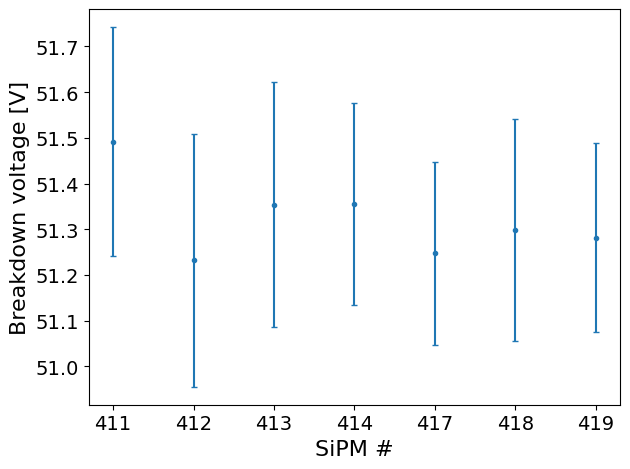

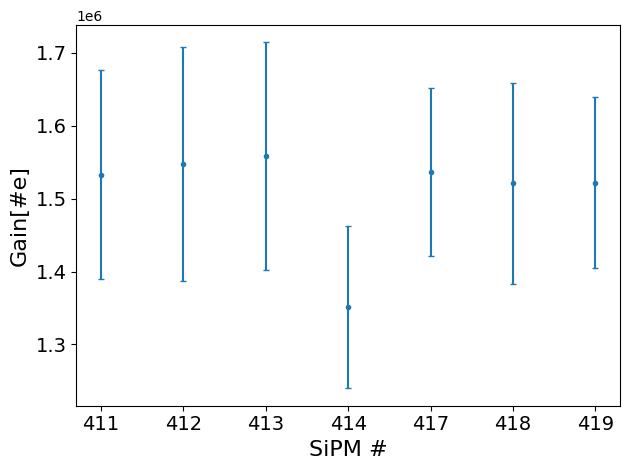

In [14]:
def plot_residuals(x, data, model, unc,fit_region , axes=None, x_scale=1):
    """Create a residuals plot on specified axes 

    Parameters
    ----------
    x : list
        x data
    data : list
        y experimental data
    model : list
        theoretical y values
    unc : list
        uncertainties on the experimental y data
    fit_region : list
        region of the fit.  NOT USED (BUT IT WILL BREAK THE CODE IF REMOVED)
    axes : matplotlib.pyplot.axes, optional
        axes object to plot on, if 'None' current axes will be used, by default None
    x_scale : int, optional
        convert x to different units (eg s to ns), by default 1

    Returns
    -------
    matplotlib.pyplot.axes
        _axes object with the residuals plot
    """
    if axes == None:
        axes = plt.gca()
    residuals = data - model
    axes.errorbar(x*x_scale, residuals, unc, fmt='.', linestyle='None')
    axes.plot(x*x_scale, np.zeros(np.shape(x)), ls='--', color='r')
    return axes


def plot_residuals_norm(x, data, model, unc,fit_region , axes=None, x_scale=1):
    """Create a normalised residuals plot on specified axes 

    Parameters
    ----------
    x : list
        x data
    data : list
        y experimental data
    model : list
        theoretical y values
    unc : list
        uncertainties on the experimental y data
    fit_region : list
        region of the fit.  NOT USED (BUT IT WILL BREAK THE CODE IF REMOVED)
    axes : matplotlib.pyplot.axes, optional
        axes object to plot on, if 'None' current axes will be used, by default None
    x_scale : int, optional
        convert x to different units (eg s to ns), by default 1

    Returns
    -------
    matplotlib.pyplot.axes
        _axes object with the normalised residuals plot
    """
    if axes == None:
        axes = plt.gca()
    unc_corr = np.where(unc == 0, np.ones(np.shape(unc)), unc)
    residuals = (data - model) / unc_corr
    axes.scatter(x*x_scale, residuals, linestyle='None')
    axes.plot(x*x_scale, np.zeros(np.shape(x)), ls='--', color='r')
    return axes


def indep_gaus_fit(histogram_areas, bins, fit_region=[-0.15e-9, 0.8e-9], method='LeastSquares', plot=False, saveplot=False, fname="", bkg="landau", plot_title=""):
    """preforms an independent fit

    Parameters
    ----------
    histogram_areas : list<float>
        list of all areas
    bins : int
        number of bins
    fit_region : list<float>, optional
        begin and end of the fit region(not all points included in the fit if the tail is too long), by default [-0.15e-9, 0.8e-9]
    method : str, optional
        cost function, 'LeastSquares' of 'likelihood', by default 'LeastSquares'
    plot : bool, optional
        print debug plots or not, by default False
    saveplot : bool, optional
        save pretty plots or not, by default False
    fname : str, optional
        filename to save the plots, by default ""
    bkg : str, optional
        distribution to model the background, 'landau', 'langauss', by default "landau"
    plot_title : str, optional
        The title to put on the plot, leave "" for no title, by default ""

    Returns
    -------
    list<float>, list<float>
        means of peaks, errors on means of peaks
    """    
    x_full = get_bin_centres(bins)
    unc = np.sqrt(histogram_areas)
    x = []
    y = []
    err = []
    bins_used = [bins[0]]
    for iterator in range(0, len(x_full)):
        if x_full[iterator] >= fit_region[0] and x_full[iterator] <= fit_region[1]:
            x.append(x_full[iterator])
            y.append(histogram_areas[iterator])
            err.append(unc[iterator])
            bins_used.append(bins[iterator + 1])
    
    err = np.array(err)
    err_corrected = np.where(err <= 1, np.full(np.shape(err), 10), err)
    bins_used = np.array(bins_used)
    y = np.array(y)
    

    #initial guesses:
    error = 1e-11
    min_error = 1e-15
    max_error = 2e-10

    mu = [0, 1.4e-10, 2.8e-10, 4.2e-10, 5.6e-10, 3e-10]
    n = 1.8e-8 / 2
    n_max = 8e-8 / 2



    x = np.array(x)
    cost_f = cost.LeastSquares(x, y, err_corrected, model)
    


    

    if(method == "likelihood"):
        cost_f = cost.ExtendedBinnedNLL(y, bins_used, model_cdf)
        
    
    p0 = [mu[0], mu[1], mu[2], mu[3], mu[4], mu[5], error, error*2.4, error*2.5, error*3, error*3, error*15, n/2, n*1.4, n*1, n*0.45, n/4, n*1.5]
    bounds_lower = [-1e-10, 0, 1e-10, 3e-10, 4e-10, 1e-10, min_error, min_error, min_error, min_error, min_error, min_error, 0, 0, 0, 0, 0, 0]
    bounds_high = [1e-10, 2.4e-10, 3.6e-10, 5e-10, 8e-10, 5e-10, max_error, max_error, max_error, max_error, max_error, max_error*10, n_max, n_max, n_max, n_max, n_max, n_max]
    fitter = Minuit(cost_f, mu1=p0[0], mu2=p0[1], mu3=p0[2], mu4=p0[3], mu5=p0[4], mu7=p0[5], err1=p0[6], err2=p0[7], err3=p0[8], err4=p0[9], err5=p0[10], err7=p0[11], n1=p0[12], n2=p0[13], n3=p0[14], n4=p0[15], n5=p0[16], n7=p0[17])
    if bkg == "langauss":
        cost_f = cost.LeastSquares(x, y, err_corrected, model_gauss)
        p0 = [mu[0], mu[1], mu[2], mu[3], mu[4], mu[5], mu[6], error, error*2.4, error*2.5, error*3, error*3, error*4, error*15, n/2, n*1.4, n*1, n*0.45, n/4, n/6, n*1.5, error*15]
        bounds_lower = [-1e-10, 0, 1e-10, 3e-10, 4e-10, 5e-10, 1e-10, min_error, min_error, min_error, min_error, min_error, min_error, min_error, 0, 0, 0, 0, 0, 0, 0, min_error]
        bounds_high = [1e-10, 2.4e-10, 3.6e-10, 5e-10, 7e-10, 8e-10, 5e-10, max_error, max_error, max_error, max_error, max_error, max_error, max_error*10, n_max, n_max, n_max, n_max, n_max, n_max, n_max, max_error*15]
        fitter = Minuit(cost_f, mu1=p0[0], mu2=p0[1], mu3=p0[2], mu4=p0[3], mu5=p0[4], mu7=p0[5], err1=p0[6], err2=p0[7], err3=p0[8], err4=p0[9], err5=p0[10], err7=p0[11], n1=p0[12], n2=p0[13], n3=p0[14], n4=p0[15], n5=p0[16], n7=p0[17], err_gauss=p0[18])
    #popt, pcov = curve_fit(model, x, histogram_areas, p0, bounds=(bounds_lower, bounds_high), maxfev=50000)
    
    

    limits_minuit = []
    for i in range(0, len(bounds_lower)):
        limits_minuit.append( (bounds_lower[i], bounds_high[i]) )
    
    fitter.limits = limits_minuit
    fitter.migrad()
    fitter.hesse()

    popt = fitter.values
    pcov = fitter.covariance
    perr = np.sqrt(np.diag(pcov))

    print(popt)
    #print(np.flatnonzero(  (err==0) ))
    #print(np.flatnonzero(  (err_corrected==0) ))
    #print(np.flatnonzero(np.isnan(histogram_areas)))
    #print(np.flatnonzero(np.isinf(histogram_areas)))
    #print(np.flatnonzero(np.isnan(x)))
    #print(np.flatnonzero(np.isinf(x)))

    if plot == True:
        plt.errorbar(x_full, histogram_areas, unc, linestyle='None', fmt='.')
        if bkg == "langauss":
            chi2(y, model_gauss(x, *popt), err_corrected)
            plt.plot(x, model_gauss(x, *popt), color='r', label='fit')
            plt.plot(x, model_gauss(x, *p0), color='g', label="Init guess")
            plt.plot(x, langauss.pdf(x, popt[6], popt[13], popt[21])*popt[20], color='r', ls='--')
            plt.plot(x, langauss.pdf(x, p0[6], p0[13], popt[21])*p0[20], color='g', ls='--')
            plt.legend()
            plt.show()
            plot_residuals(x, y, model_gauss(x, *popt), err_corrected, fit_region)
        else:
        
            chi2(y, model(x, *popt), err_corrected)
        
            plt.plot(x, model(x, *popt), color='r', label='fit')
            plt.plot(x, model(x, *p0), color='g', label="Init guess")
            plt.plot(x, landau.pdf(x, popt[5], popt[11])*popt[17], color='r', ls='--')
            plt.plot(x, landau.pdf(x, p0[5], p0[11])*p0[17], color='g', ls='--')
            plt.legend()
            plt.show()            
            plot_residuals(x, y, model(x, *popt), err_corrected, fit_region)

        #fig, axes = plt.subplots(1, 1)
        #plot_residuals(x, y, model(x, *p0), err_corrected, axes[0])
        
        plt.show()

    if saveplot == True:
        
        fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        #fig.tight_layout(pad=0.8)
        fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92, wspace=0.005, hspace=0.1)

        fig.set_size_inches(16, 9)
        axes[0].errorbar(np.array(x_full) * 10**9, histogram_areas, unc, linestyle='None', fmt='.')
        if bkg == "langauss":
            chi2(y, model_gauss(x, *popt), err_corrected)
            axes[0].plot(x * 10**9, model_gauss(x, *popt), color='r', label='model')
            axes[0].plot(x * 10**9, langauss.pdf(x, popt[5], popt[11], popt[21])*popt[20], color='r', ls='--', label="background")
            plot_residuals(np.array(x_full), histogram_areas, model_gauss(np.array(x_full), *popt), unc, fit_region, axes[1], 10**9)
        else:
            chi2(y, model(x, *popt), err_corrected)
            axes[0].plot(x * 10**9, model(x, *popt), color='r', label='model')
            axes[0].plot(x * 10**9, landau.pdf(x, popt[5], popt[11])*popt[17], color='r', ls='--', label="background")
            plot_residuals_norm(np.array(x_full), histogram_areas, model(np.array(x_full), *popt), unc, fit_region, axes[1], 10**9)
        axes[1].set_xlabel("Charge [nV.s]", fontsize=22)
        x_span = x_full[-1] - x_full[0]

        axes[0].set_ylabel("Entries [{0:3.1f} counts / (nV.ms)]".format(x_span / len(x_full) * 10**12), fontsize=22)
        axes[1].set_ylabel("Residuals", fontsize=22)
        axes[0].legend(fontsize="20")
        axes[0].tick_params(axis='y', labelsize=15)
        axes[1].tick_params(axis='both', labelsize=15)
        if plot_title != "":
            axes[0].set_title(plot_title, fontsize=23)
        loc = PLOTS_FOLDER
        fig.savefig(loc+fname)
        
        plt.show()




    means = [popt[0], popt[1], popt[2], popt[3], popt[4] ]
    err_means = [perr[0], perr[1], perr[2], perr[3], perr[4] ]

    return means, err_means


def dep_gaus_fit(histogram_areas, bins, fit_region=[-0.15e-9, 0.8e-9], method='LeastSquares', plot=False, saveplot=False, fname="", p0=None, plot_title=""):
    """preforms a dependent fit

    Parameters
    ----------
    histogram_areas : list<float>
        list of all areas
    bins : int
        number of bins
    fit_region : list<float>, optional
        begin and end of the fit region(not all points included in the fit if the tail is too long), by default [-0.15e-9, 0.8e-9]
    method : str, optional
        cost function, 'LeastSquares' of 'likelihood', by default 'LeastSquares'
    plot : bool, optional
        print debug plots or not, by default False
    saveplot : bool, optional
        save pretty plots or not, by default False
    fname : str, optional
        filename to save the plots, by default ""
    bkg : str, optional
        distribution to model the background, 'landau', 'langauss', by default "landau"
    plot_title : str, optional
        The title to put on the plot, leave "" for no title, by default ""

    Returns
    -------
    list<float>, list<float>, list<float>, list<float>, list<float>, list<float>
        gains, error gains, sigma gain, error sigma gain, sigma pedestal, error sigma pedestal
    """    
    #format the input data
    x_full = get_bin_centres(bins)
    unc = np.sqrt(histogram_areas)
    x = []
    y = []
    err = []
    bins_used = [bins[0]]
    for iterator in range(0, len(x_full)):
        if x_full[iterator] >= fit_region[0] and x_full[iterator] <= fit_region[1]:
            x.append(x_full[iterator])
            y.append(histogram_areas[iterator])
            err.append(unc[iterator])
            bins_used.append(bins[iterator + 1])
    
    err = np.array(err)
    err_corrected = np.where(err <= 1, np.full(np.shape(err), 10), err)
    bins_used = np.array(bins_used)
    y = np.array(y)
    x = np.array(x)
    
    if p0 == None:
        #define the indep params with initial guesses
        #Those are initial guesses for 56V
        mu1 = 0
        err1 = 1.15e-11
        G = 1.39e-10
        erri = 1.27e-11

        mu_bkg = 1e-10
        err_bkg = 1.1e-10

        n = 1.8e-8 / 2
        n_max = 8e-8 / 2

        p0 = [mu1, err1, G, erri, mu_bkg, err_bkg, n/2, n, n/3, n/4, n/5, n]

    #initialize Minuit object
    cost_f = cost.LeastSquares(x, y, err_corrected, dep_model)

    fitter = Minuit(cost_f, *p0)

    fitter.migrad()
    fitter.hesse()
    #fitter.minos()

    popt = fitter.values
    pcov = fitter.covariance
    perr = [0, 0, 0]
    try:
        perr = fitter.errors
        #print(fitter.merrors[2])
    except:
        print("Hessian could not be computed")
    
    if plot == True:
        chi2(y, dep_model(x, *popt), err_corrected, len(popt))
        plt.errorbar(x_full, histogram_areas, unc, linestyle='None', fmt='.')
        plt.plot(x, dep_model(x, *popt), color='r', label='fit')
        plt.plot(x, dep_model(x, *p0), color='g', label="Init guess")
        plt.plot(x, landau.pdf(x, popt[4], popt[5])*popt[11], color='r', ls='--')
        plt.plot(x, landau.pdf(x, p0[4], p0[5])*p0[11], color='g', ls='--')
        plt.legend()
        plt.show()

    if saveplot == True:
        fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        #fig.tight_layout(pad=0.8)
        fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.99, wspace=0.005, hspace=0.1)

        fig.set_size_inches(16, 9)
        axes[0].errorbar(np.array(x_full) * 10**9, histogram_areas, unc, linestyle='None', fmt='.')
        chi2(y, dep_model(x, *popt), err_corrected)
        axes[0].plot(x * 10**9, dep_model(x, *popt), color='r', label='model')
        axes[0].plot(x * 10**9, landau.pdf(x, popt[4], popt[5])*popt[11], color='r', ls='--', label="background")
        plot_residuals_norm(np.array(x_full), histogram_areas, dep_model(np.array(x_full), *popt), unc, fit_region, axes[1], 10**9)
        axes[1].set_xlabel("Charge [nV.s]", fontsize=22)
        x_span = x_full[-1] - x_full[0]

        axes[0].set_ylabel("Entries [{0:3.1f} counts / (nV.ms)]".format(x_span / len(x_full) * 10**12), fontsize=22)
        axes[1].set_ylabel("Residuals", fontsize=22)
        axes[0].legend(fontsize=22)
        axes[0].tick_params(axis='y', labelsize=15)
        axes[1].tick_params(axis='both', labelsize=15)
        if plot_title != "":
            axes[0].set_title(plot_title, fontsize=23)
        
        loc = PLOTS_FOLDER
        fig.savefig(loc+fname)
        
        plt.show()


    print(popt)
    return popt[2], perr[2], popt[3], perr[3], popt[1], perr[1]


def plot_gain(means=[], err_means=[]):
    """To be used with the independetn fit.  Plots the peak location against 
    peak number and finds the slope (gain)

    Parameters
    ----------
    means : list, optional
        locations of peaks, by default []
    err_means : list, optional
        uncertainties of locations, by default []
    """
    x = np.linspace(0, 4, 5)
    popt, pcov = curve_fit(linear, x, means, sigma=err_means, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))

    plt.plot(x, linear(x, *popt), color='b')
    plt.errorbar(x, means, err_means, fmt='.', ls='None', color='r', capsize=4)
    plt.xlabel("peak #")
    plt.ylabel("Charge[V.s]")
    plt.title("Mean of peak vs peak number")
    plt.savefig(PLOTS_FOLDER + "example_gains_fit.png")
    plt.show()
    chi2(np.array(means), linear(x, *popt), np.array(err_means), 2)
    print(popt, perr)

    return

def procedure_indep_fit(sipm_no=411, voltage="56V", Ch=None, bin_count=600, fit_region=[-1.5e-10, 8e-10], save=False):
    """Procedure to read the areas from a file and perform the independent fit.  To be used after procedure_areas_save

    Parameters
    ----------
    sipm_no : int, optional
        The number of the sipm as written in the data file names, by default 411
    voltage : str, optional
        voltage as written in the data file names, by default "56V"
    Ch : _type_, optional
        channel prefix added by scope, by default None
    bin_count : int, optional
        bin count, by default 600
    fit_region : list, optional
        Region to fit in if not all data is to be included in the fit due to long meaningless tail, by default [-1.5e-10, 8e-10]
    save : bool, optional
        save pretty plots or not, by default False

    Returns
    -------
    list, list
        means , errors of means
    """
    fname =  "areas_sipm-" + str(sipm_no) + "_" + voltage +".csv"
    if Ch != None:
        fname = Ch + "--" + fname
    location = DATA_FOLDER
    areas = np.genfromtxt(location + fname, delimiter=',')
    hist, bins = np.histogram(areas, bins=bin_count)
    means, err_means = indep_gaus_fit(hist, bins, fit_region, plot=True, saveplot=save, fname="areas_fit_" + str(sipm_no) + "_" + voltage + ".png", plot_title="Independent fit for SiPM " + str(sipm_no) + " at " + voltage)
    return means, err_means

def procedure_dep_fit(sipm_no=411, voltage="56V", bin_size=2.7e-12, fit_region=[-1.5e-10, 8e-10], save=False, p0=[], plot_title=False):
    """Procedure to read the areas from a file and perform the dependent fit.  To be used after procedure_areas_save

    Parameters
    ----------
    sipm_no : int, optional
        sipm number as written in the areas data file, by default 411
    voltage : str, optional
        voltage as written in the areas data file, by default "56V"
    bin_size : float, optional
        the size of each bin, to ensure equal bin size over different voltages, by default 2.7e-12
    fit_region : list, optional
        Region to fit in if not all data is to be included in the fit due to long meaningless tail, by default [-1.5e-10, 8e-10]
    save : bool, optional
        save pretty plot or not, by default False
    p0 : list, optional
        initial parameters for the fit, by default []
    plot_title : bool, optional
        add title to plot or not, by default False

    Returns
    -------
    list, list, list, list, list, list
        gain, err_gain, sigma_cell, err_sigma_cell, sigma_pedestal, err_sigma_pedestal
    """
    fname =  "areas_sipm-" + str(sipm_no) + "_" + voltage +".csv"
    #if Ch != None:
    #    fname = Ch + "--" + fname
    location = DATA_FOLDER
    areas = np.genfromtxt(location + fname, delimiter=',')
    areas_span = np.max(areas) - np.min(areas)
    
    bin_count = int(areas_span / bin_size)
    #print(bin_count)
    hist, bins = np.histogram(areas, bins=bin_count)
    title = ""
    if plot_title == True:
        title = "Dependent fit for SiPM " + str(sipm_no) + " at " + voltage
    gain, err_gain, sigma_cell, err_sigma_cell, sigma_pedestal, err_sigma_pedestal = dep_gaus_fit(hist, bins, fit_region, plot=True, saveplot=save, fname="areas_fit_dep_" + str(sipm_no) + "_" + voltage + ".png", p0=p0, plot_title=title)
    return gain, err_gain, sigma_cell, err_sigma_cell, sigma_pedestal, err_sigma_pedestal


def do_all_fits(fitting_procedure, sipm_no=411, voltage=[54, 59], bin_size=2.7e-12, save=False, plot=False):
    """Call the fitting procedure function to perform fits for all voltages with a single SiPM
    Calculate SNR, breakdown voltage and save these results to a csv file in the results folder

    Parameters
    ----------
    fitting_procedure : callable
        The fitting procedure function, either 'procedure_dep_fit' or 'procedure_indep_fit'
    sipm_no : int, optional
        the sipm number as written in the areas file name, by default 411
    voltage : list, optional
        lower and upper limit of voltages to iterate over, by default [54, 59]
    bin_size : float, optional
        size of bins for all voltages, by default 2.7e-12
    save : bool, optional
        save pretty plots or not, by default False
    plot : bool, optional
        print debug plots or not, by default False
    """
    gains = []
    err_gains = []

    cell_sigmas = []
    err_cell_sigmas = []

    pedestal_sigmas = []
    err_pedestal_sigmas = []

    voltages = []

    #some initial parameters
    roi = [-0.5e-10, 4e-10]
    mu1 = 0
    err1 = 1e-11
    G = 0.75e-10
    erri = 1.27e-11
    mu_bkg = 0.1e-10
    err_bkg = 0.6e-10
    n = 1.8e-8 
    n_bkg = n

    for V in range(voltage[0], voltage[-1] + 1):
        voltages.append(V)
        V_string = str(V) + "V"
        print("==========================================")
        print("Fitting for " + V_string)
        p0 = [mu1, err1, G, erri, mu_bkg, err_bkg, n/1.2, n/1.5, n/3, n/10, 0, n_bkg]
        gain, error_gain, sigma_cell, error_sigma_cell, sigma_pedestal, error_sigma_pedestal = fitting_procedure(sipm_no, V_string, bin_size, roi, save, p0)
        gains.append(gain)
        err_gains.append(error_gain)
        cell_sigmas.append(sigma_cell)
        err_cell_sigmas.append(error_sigma_cell)
        pedestal_sigmas.append(sigma_pedestal)
        err_pedestal_sigmas.append(error_sigma_pedestal)
        G += 0.325e-10
        mu_bkg += 0.15e-10
        roi[0] -= 0.5e-10
        roi[1] += 2e-10
        err_bkg += 0.2e-10
        n_bkg += n / 2
        n /= np.sqrt(2)

    voltages = np.array(voltages)
    gains = np.array(gains)
    err_gains = np.array(err_gains)
    cell_sigmas = np.array(cell_sigmas)
    err_cell_sigmas = np.array(err_cell_sigmas)
    pedestal_sigmas = np.array(pedestal_sigmas)
    err_pedestal_sigmas = np.array(err_pedestal_sigmas)



    #-------------------------Gain Voltage curve----------------------------------------
    popt, pcov = curve_fit(linear, voltages, gains, sigma=err_gains, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    ampl_factor = 10.1 * 50
    gains_e = gains / 1.6e-19 / ampl_factor
    err_gains_e = err_gains / 1.6e-19 /ampl_factor
    plt.errorbar(voltages, gains_e, err_gains_e , ls='None', fmt='.', capsize=5.0)
    plt.plot(voltages, linear(voltages, *popt) / 1.6e-19 /ampl_factor)
    plt.xlabel("Voltage[V]")
    plt.ylabel("Gain [#e]")
    plt.title("Gain-Voltage curve")
    #plt.plot(voltages, np.zeros(np.shape(voltages)), color='r', ls='--')
    breakdown_V = -popt[1] / popt[0]
    err_breakdown_V = breakdown_V * np.sqrt( (perr[0] / popt[0])**2 + (perr[1] / popt[1])**2 )
    chi2(gains, linear(voltages, *popt), err_gains, 2)
    print( "The breakdown voltage is: {0:3.1f} +/- {1:3.1f}".format(breakdown_V, err_breakdown_V))


    if plot == True:
        fname = "gain_voltage_sipm-" + str(sipm_no) + ".png"
        loc = PLOTS_FOLDER
        plt.savefig(loc + fname)

    plt.show()



    #-------------------------SNR Calculation------------------------------------------

    delimiter = pedestal_sigmas**2 + cell_sigmas**2 
    SNR = gains / np.sqrt(delimiter)
    part_err_delimiter =  np.sqrt( (err_pedestal_sigmas * pedestal_sigmas * 2)**2 + (err_cell_sigmas * cell_sigmas *2)**2)
    err_delimiter = part_err_delimiter / (2 * np.sqrt(delimiter))
    err_SNR = SNR * np.sqrt((err_gains / gains)**2 + (err_delimiter / np.sqrt(delimiter))**2)
    fname = "snr_sipm-" + str(sipm_no) + ".png"
    plt.errorbar(voltages, SNR, err_SNR, fmt='.', ls='None', capsize=2)
    plt.xlabel("Voltage[V]")
    plt.ylabel("SNR")
    if plot == True:
        plt.savefig(loc + fname)
    plt.show()
    


    #----------------------save results------------------------------------------------
    voltages = np.array([voltages])
    gains = np.array([gains_e])
    err_gains = np.array([err_gains_e])
    SNR = np.array([SNR])
    err_SNR = np.array([err_SNR])

    results = np.concatenate([voltages.T, gains.T, err_gains.T, SNR.T, err_SNR.T], axis=1)
    loc = RESULTS_FOLDER
    fname = "results_sipm-" + str(sipm_no) + ".csv"
    if plot == True:
        np.savetxt(loc+fname, results, delimiter=',', header='voltage[V], gain[#e], err_gain[#e], SNR, err_SNR')
        print("Saved gains and SNR to file: " + loc + fname)


def overvoltages_plot(sipm_no=[411, 412, 413, 414, 417, 418, 419], voltage=4):
    """Reads data from the results folder and plots all gains at a certain overvoltage

    Parameters
    ----------
    sipm_no : list, optional
        numbers of sipms to be plotted, by default [411, 412, 413, 414, 417, 418, 419]
    voltage : int, optional
        the overvoltage to plot for, by default 4
    """
    G_overvoltage = []
    err_G_overvoltage = []
    breakdowns = []
    err_breakdowns = []
    for sipm in sipm_no:
        loc = RESULTS_FOLDER
        fname = "results_sipm-" + str(sipm) + ".csv"
        data = np.genfromtxt(loc+fname, delimiter=',', skip_header=1)
        data[:, 1] /= 500
        data[:, 2] /= 500
        p0=[ 1.68893835e+06, -8.67367450e+07]
        popt, pcov = curve_fit(linear, data[:, 0], data[:, 1], sigma=data[:, 2], absolute_sigma=True, p0=p0)
        perr = np.sqrt(np.diag(pcov))
        breakdown_V = -popt[1] / popt[0]
        err_breakdown_V = breakdown_V * np.sqrt( (perr[0] / popt[0])**2 + (perr[1] / popt[1])**2 )
        V = breakdown_V + voltage
        G = popt[0] * V + popt[1]
        err_G_1 = popt[0] * V * np.sqrt( (perr[0] / popt[0])**2 + (err_breakdown_V / breakdown_V)**2 )
        err_G = np.sqrt(err_G_1**2 + perr[1]**2)
        G_overvoltage.append(G)
        err_G_overvoltage.append(err_G)
        breakdowns.append(breakdown_V)
        err_breakdowns.append(err_breakdown_V)
        #debug plot
        print(breakdown_V, err_breakdown_V)
        print(G, err_G)
        #plt.errorbar(data[:, 0], data[:, 1], data[:, 2], ls='None', fmt='.')
        #plt.plot(data[:, 0], linear(data[:, 0], *popt))
        #plt.show()

    x = np.linspace(1, len(sipm_no), len(sipm_no))
    plt.errorbar(x, breakdowns, err_breakdowns, fmt='.', ls='None', capsize=2)
    plt.xticks(x, sipm_no)
    plt.xlabel("SiPM #", fontsize=16)
    plt.ylabel("Breakdown voltage [V]", fontsize=16)
    plt.tick_params('both', labelsize=14)
    plt.tight_layout()
    plt.savefig(PLOTS_FOLDER + "breakdown_V_all.png", dpi=600)
    plt.show()

    plt.errorbar(x, G_overvoltage, err_G_overvoltage, ls='None', fmt='.', capsize=2)
    plt.xticks(x, sipm_no)
    plt.xlabel("SiPM #", fontsize=16)
    plt.ylabel("Gain[#e]", fontsize=16)
    plt.tick_params('both', labelsize=14)
    plt.tight_layout()
    
    plt.savefig(PLOTS_FOLDER + "4_overvolts_all.png", dpi=600)
    plt.show()
    
    

if __name__ == "__main__":
    overvoltages_plot()